In [1]:
!pip install -q transformers datasets accelerate scikit-learn

import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

Device: cuda


In [2]:
TRAIN_PATH = "train_CG.csv"
DEV_PATH   = "dev_CG.csv"
TEST_PATH  = "test_data_withoutlabelCG.csv"

MODEL_NAME = "xlm-roberta-base"
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE  = 32
LR = 2e-5
NUM_EPOCHS = 8
WARMUP_RATIO = 0.1
EARLY_STOP_PATIENCE = 2   # epochs of no dev macro-F1 improvement


In [3]:
# Try to infer whether there is a header.
# If the first line contains non-text label (e.g., "Text"), pandas will treat as header automatically.
train_df = pd.read_csv(TRAIN_PATH)
dev_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train head:")
print(train_df.head())
print("Dev head:")
print(dev_df.head())
print("Test head:")
print(test_df.head())

# Standardize column names if needed
# Expecting train/dev: "Text", "Label"
# Test: "ID", "Text"
if "Text" not in train_df.columns or "Label" not in train_df.columns:
    # Assume exactly two columns if header is missing
    train_df.columns = ["Text", "Label"]
if "Text" not in dev_df.columns or "Label" not in dev_df.columns:
    dev_df.columns = ["Text", "Label"]
if "Text" not in test_df.columns:
    # Assume first column ID, second Text
    test_df.columns = ["ID", "Text"]

# Strip whitespace from text and labels
train_df["Text"] = train_df["Text"].astype(str).str.strip()
dev_df["Text"]   = dev_df["Text"].astype(str).str.strip()
test_df["Text"]  = test_df["Text"].astype(str).str.strip()
train_df["Label"] = train_df["Label"].astype(str).str.strip()
dev_df["Label"]   = dev_df["Label"].astype(str).str.strip()

Train head:
                                                Text              Label
0      Santhu nu masth miss malthondu ullar bro 🤔🤔🤔🤔         uninvolved
1   Undhe n YouTube d thooyere andala mobile bodathe  discouraging hope
2  ತಟ್ಟಿ ನುಂಗೆಲ್ ತಾರೆದ ಮಡಲ್‌ನ್ ನೀರ್‌ಡ್ ಪಾಡ್ದ್ ಅವು...         uninvolved
3                            Super comedy deepak rai   encouraging hope
4                Namma tulundadu comedy first eppodu         uninvolved
Dev head:
                                                Text             Label
0                      Yeranda narrd korle marre 😂😂😂        uninvolved
1  Tulu barpundge areg. Wow mokedha base tulu. Ja...  encouraging hope
2                          Bಅರಿ ಪೊರ್ಲು ದ ಬಲೆ telpale  encouraging hope
3                        bayya poora film padlethe..  encouraging hope
4  Super act super comedy deepak jp thumbinadu ra...  encouraging hope
Test head:
         ID                                               Text
0  Tu_CG_01  Video masth edde aathnd, but star

In [4]:
# ============================
# 3. Label mapping and class weights
# ============================

# Explicit mapping to avoid any mismatch
label_list = ["encouraging hope", "discouraging hope", "uninvolved", "blended hope"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

train_df["label_id"] = train_df["Label"].map(label2id)
dev_df["label_id"]   = dev_df["Label"].map(label2id)

print("\nLabel distribution (train):")
print(train_df["Label"].value_counts(dropna=False))

# Compute class weights: N / (num_classes * count_c)
num_classes = len(label_list)
class_counts = train_df["label_id"].value_counts().reindex(range(num_classes), fill_value=0)
N = len(train_df)
class_weights = N / (num_classes * class_counts.values.astype(float))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ---- NEW: boost minority classes ----
# ids: 0=encouraging, 1=discouraging, 2=uninvolved, 3=blended
boost_factor_disc = 1.6   # try 1.3–1.5
boost_factor_blend = 1.4  # try 1.2–1.4

class_weights[1] = class_weights[1] * boost_factor_disc   # discouraging hope
class_weights[3] = class_weights[3] * boost_factor_blend  # blended hope

# optional: normalize so average weight ~1
class_weights = class_weights / class_weights.mean()

print("\nClass counts:", class_counts.to_dict())
print("Adjusted class weights:", class_weights)


Label distribution (train):
Label
uninvolved           2490
encouraging hope     1895
blended hope          895
discouraging hope     711
Name: count, dtype: int64

Class counts: {0: 1895, 1: 711, 2: 2490, 3: 895}
Adjusted class weights: tensor([0.4450, 1.8975, 0.3386, 1.3190], device='cuda:0')


In [5]:
# ============================
# 4. Dataset & DataLoader
# ============================

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TuluHopeDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=96):
        self.texts = list(texts)
        self.labels = labels if labels is not None else None
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

        if self.labels is not None:
            item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)

        return item

train_dataset = TuluHopeDataset(
    texts=train_df["Text"].tolist(),
    labels=train_df["label_id"].tolist(),
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)

dev_dataset = TuluHopeDataset(
    texts=dev_df["Text"].tolist(),
    labels=dev_df["label_id"].tolist(),
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)

test_dataset = TuluHopeDataset(
    texts=test_df["Text"].tolist(),
    labels=None,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [6]:
# ============================
# 5. Model, optimizer, scheduler
# ============================

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.dense.weight        | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
classifier.out_proj.weight  | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.weight     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [7]:
# ============================
# 6. Training & evaluation loop
# ============================

def evaluate(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    report = classification_report(
        all_labels,
        all_preds,
        target_names=label_list,
        digits=4,
    )
    return macro_f1, report

best_dev_f1 = -1.0
epochs_no_improve = 0
best_model_path = "best_tulu_hope_xlmr.pt"

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    dev_f1, dev_report = evaluate(model, dev_loader)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.4f}")
    print(f"Dev macro F1: {dev_f1:.4f}")
    print("Dev classification report:")
    print(dev_report)

    # Early stopping
    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(">> New best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(">> Early stopping triggered.")
            break

print(f"\nBest dev macro F1: {best_dev_f1:.4f}")


Epoch 1/8
Train loss: 1.3370
Dev macro F1: 0.4220
Dev classification report:
                   precision    recall  f1-score   support

 encouraging hope     0.8044    0.4458    0.5737       406
discouraging hope     0.1818    0.7974    0.2961       153
       uninvolved     0.9046    0.5506    0.6845       534
     blended hope     0.2698    0.0890    0.1339       191

         accuracy                         0.4782      1284
        macro avg     0.5402    0.4707    0.4220      1284
     weighted avg     0.6924    0.4782    0.5213      1284

>> New best model saved.

Epoch 2/8
Train loss: 1.1702
Dev macro F1: 0.5049
Dev classification report:
                   precision    recall  f1-score   support

 encouraging hope     0.7811    0.6502    0.7097       406
discouraging hope     0.3056    0.1438    0.1956       153
       uninvolved     0.8473    0.6442    0.7319       534
     blended hope     0.2692    0.6597    0.3824       191

         accuracy                         0.588

In [8]:
# ============================
# 7. Load best model & inference on test
# ============================

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_test_ids = test_df["ID"].tolist()
all_test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_test_preds.extend(preds.cpu().numpy())

# Map back to label strings
pred_labels = [id2label[int(i)] for i in all_test_preds]

submission = pd.DataFrame({
    "ID": all_test_ids,
    "Text": test_df["Text"].tolist(),
    "Label": pred_labels,
})

SUBMISSION_PATH = "submission_task1_xlmroberta.csv"
submission.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8")
print(f"\nSaved submission file: {SUBMISSION_PATH}")
print(submission.head())



Saved submission file: submission_task1_xlmroberta.csv
         ID                                               Text  \
0  Tu_CG_01  Video masth edde aathnd, but starting d avvu k...   
1  Tu_CG_02              Imbye boka itte urchve encha marre!!?   
2  Tu_CG_03                Parondh yeth thindaaa...onja radda️   
3  Tu_CG_04                          Kudlada jaatilu religion"   
4  Tu_CG_05                                va comedy va comedy   

               Label  
0       blended hope  
1       blended hope  
2       blended hope  
3         uninvolved  
4  discouraging hope  


In [9]:
import numpy as np

model.eval()
all_dev_logits = []
all_dev_labels = []

with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch, 4]

        all_dev_logits.append(logits.cpu().numpy())
        all_dev_labels.append(labels.cpu().numpy())

dev_logits = np.concatenate(all_dev_logits, axis=0)
dev_labels = np.concatenate(all_dev_labels, axis=0)

np.save("xlmr_dev_logits.npy", dev_logits)
# Save dev_labels once; reuse for all models
np.save("dev_labels.npy", dev_labels)


In [10]:
model.eval()
all_test_logits = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch, 4]
        all_test_logits.append(logits.cpu().numpy())

test_logits = np.concatenate(all_test_logits, axis=0)
np.save("xlmr_test_logits.npy", test_logits)


In [11]:
!pip install -q transformers accelerate scikit-learn

import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

# 1. Paths and config
TRAIN_PATH = "train_CG.csv"
DEV_PATH   = "dev_CG.csv"
TEST_PATH  = "test_data_withoutlabelCG.csv"

MODEL_NAME = "google/muril-base-cased"   # <-- changed to MuRIL
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE  = 32
LR = 2e-5
NUM_EPOCHS = 8
WARMUP_RATIO = 0.1
EARLY_STOP_PATIENCE = 2

# 2. Load data
train_df = pd.read_csv(TRAIN_PATH)
dev_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)

if "Text" not in train_df.columns or "Label" not in train_df.columns:
    train_df.columns = ["Text", "Label"]
if "Text" not in dev_df.columns or "Label" not in dev_df.columns:
    dev_df.columns = ["Text", "Label"]
if "Text" not in test_df.columns:
    test_df.columns = ["ID", "Text"]

train_df["Text"] = train_df["Text"].astype(str).str.strip()
dev_df["Text"]   = dev_df["Text"].astype(str).str.strip()
test_df["Text"]  = test_df["Text"].astype(str).str.strip()
train_df["Label"] = train_df["Label"].astype(str).str.strip()
dev_df["Label"]   = dev_df["Label"].astype(str).str.strip()

# 3. Labels and class weights
label_list = ["encouraging hope", "discouraging hope", "uninvolved", "blended hope"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

train_df["label_id"] = train_df["Label"].map(label2id)
dev_df["label_id"]   = dev_df["Label"].map(label2id)

print("\nLabel distribution (train):")
print(train_df["Label"].value_counts(dropna=False))

num_classes = len(label_list)
class_counts = train_df["label_id"].value_counts().reindex(range(num_classes), fill_value=0)
N = len(train_df)
class_weights = N / (num_classes * class_counts.values.astype(float))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# stronger boost like your last XLM-R run
boost_factor_disc = 1.6
boost_factor_blend = 1.4
class_weights[1] *= boost_factor_disc
class_weights[3] *= boost_factor_blend
class_weights = class_weights / class_weights.mean()

print("\nClass counts:", class_counts.to_dict())
print("Adjusted class weights:", class_weights)

# 4. Dataset & DataLoader
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TuluHopeDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = list(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_dataset = TuluHopeDataset(train_df["Text"], train_df["label_id"], tokenizer, MAX_LENGTH)
dev_dataset   = TuluHopeDataset(dev_df["Text"],   dev_df["label_id"],   tokenizer, MAX_LENGTH)
test_dataset  = TuluHopeDataset(test_df["Text"],  None,                 tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(dev_dataset,   batch_size=EVAL_BATCH_SIZE,  shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=EVAL_BATCH_SIZE,  shuffle=False)

# 5. Model, optimizer, scheduler
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# 6. Training & evaluation
def evaluate(model, data_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    report = classification_report(all_labels, all_preds, target_names=label_list, digits=4)
    return macro_f1, report

best_dev_f1 = -1.0
epochs_no_improve = 0
best_model_path = "best_tulu_hope_muril.pt"

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    dev_f1, dev_report = evaluate(model, dev_loader)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.4f}")
    print(f"Dev macro F1: {dev_f1:.4f}")
    print("Dev classification report:")
    print(dev_report)

    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(">> New best MuRIL model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(">> Early stopping triggered.")
            break

print(f"\nBest MuRIL dev macro F1: {best_dev_f1:.4f}")


Device: cuda

Label distribution (train):
Label
uninvolved           2490
encouraging hope     1895
blended hope          895
discouraging hope     711
Name: count, dtype: int64

Class counts: {0: 1895, 1: 711, 2: 2490, 3: 895}
Adjusted class weights: tensor([0.4450, 1.8975, 0.3386, 1.3190], device='cuda:0')


config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: google/muril-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expe


Epoch 1/8
Train loss: 1.3658
Dev macro F1: 0.2777
Dev classification report:
                   precision    recall  f1-score   support

 encouraging hope     0.0000    0.0000    0.0000       406
discouraging hope     0.1693    0.8431    0.2820       153
       uninvolved     0.8096    0.6292    0.7081       534
     blended hope     0.1682    0.0942    0.1208       191

         accuracy                         0.3762      1284
        macro avg     0.2868    0.3916    0.2777      1284
     weighted avg     0.3819    0.3762    0.3461      1284

>> New best MuRIL model saved.

Epoch 2/8
Train loss: 1.2061
Dev macro F1: 0.5459
Dev classification report:
                   precision    recall  f1-score   support

 encouraging hope     0.8206    0.6872    0.7480       406
discouraging hope     0.2868    0.5098    0.3671       153
       uninvolved     0.8657    0.6760    0.7592       534
     blended hope     0.2706    0.3613    0.3094       191

         accuracy                        

In [12]:
# ============================
# 7. Load best MuRIL & save logits
# ============================
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

import numpy as np

# Dev logits + labels
all_dev_logits, all_dev_labels = [], []
with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        all_dev_logits.append(logits.cpu().numpy())
        all_dev_labels.append(labels.cpu().numpy())

muril_dev_logits = np.concatenate(all_dev_logits, axis=0)
dev_labels = np.concatenate(all_dev_labels, axis=0)  # redundant but fine

np.save("muril_dev_logits.npy", muril_dev_logits)
# dev_labels.npy already saved from XLM-R; saving again is optional.

# Test logits
all_test_logits = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        all_test_logits.append(logits.cpu().numpy())

muril_test_logits = np.concatenate(all_test_logits, axis=0)
np.save("muril_test_logits.npy", muril_test_logits)

print("Saved muril_dev_logits.npy and muril_test_logits.npy")

Saved muril_dev_logits.npy and muril_test_logits.npy


In [13]:
# 7. Load best model & inference on test

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_test_ids = test_df["ID"].tolist()
all_test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_test_preds.extend(preds.cpu().numpy())

# Map back to label strings
pred_labels = [id2label[int(i)] for i in all_test_preds]

submission = pd.DataFrame({
    "ID": all_test_ids,
    "Text": test_df["Text"].tolist(),
    "Label": pred_labels,
})

SUBMISSION_PATH = "submission_task1_muril.csv"
submission.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8")
print(f"\nSaved submission file: {SUBMISSION_PATH}")
print(submission.head())



Saved submission file: submission_task1_muril.csv
         ID                                               Text  \
0  Tu_CG_01  Video masth edde aathnd, but starting d avvu k...   
1  Tu_CG_02              Imbye boka itte urchve encha marre!!?   
2  Tu_CG_03                Parondh yeth thindaaa...onja radda️   
3  Tu_CG_04                          Kudlada jaatilu religion"   
4  Tu_CG_05                                va comedy va comedy   

               Label  
0       blended hope  
1       blended hope  
2         uninvolved  
3         uninvolved  
4  discouraging hope  


In [14]:
import numpy as np
from sklearn.metrics import f1_score

dev_labels = np.load("dev_labels.npy")
xlmr_dev = np.load("xlmr_dev_logits.npy")
muril_dev = np.load("muril_dev_logits.npy")

# Individual
pred_xlmr = xlmr_dev.argmax(axis=1)
pred_muril = muril_dev.argmax(axis=1)
print("XLM-R dev macro F1:", f1_score(dev_labels, pred_xlmr, average="macro"))
print("MuRIL dev macro F1:", f1_score(dev_labels, pred_muril, average="macro"))

# Simple average ensemble
ens_dev = (xlmr_dev + muril_dev) / 2.0
pred_ens = ens_dev.argmax(axis=1)
print("Ensemble dev macro F1:", f1_score(dev_labels, pred_ens, average="macro"))

XLM-R dev macro F1: 0.6059053682960213
MuRIL dev macro F1: 0.5913505938348677
Ensemble dev macro F1: 0.6222621711253484


In [ ]:
!pip install -q transformers accelerate scikit-learn

import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================
# 1. Seed & paths
# ============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

TRAIN_PATH = "train_CG.csv"
DEV_PATH   = "dev_CG.csv"
TEST_PATH  = "test_data_withoutlabelCG.csv"

MODEL_NAME = "bert-base-multilingual-cased"   # <-- public IndicBERT
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE  = 32
LR = 2e-5
NUM_EPOCHS = 8
WARMUP_RATIO = 0.1
EARLY_STOP_PATIENCE = 2

# ============================
# 2. Load data
# ============================
train_df = pd.read_csv(TRAIN_PATH)
dev_df   = pd.read_csv(DEV_PATH)
test_df  = pd.read_csv(TEST_PATH)

if "Text" not in train_df.columns or "Label" not in train_df.columns:
    train_df.columns = ["Text", "Label"]
if "Text" not in dev_df.columns or "Label" not in dev_df.columns:
    dev_df.columns = ["Text", "Label"]
if "Text" not in test_df.columns:
    test_df.columns = ["ID", "Text"]

train_df["Text"] = train_df["Text"].astype(str).str.strip()
dev_df["Text"]   = dev_df["Text"].astype(str).str.strip()
test_df["Text"]  = test_df["Text"].astype(str).str.strip()
train_df["Label"] = train_df["Label"].astype(str).str.strip()
dev_df["Label"]   = dev_df["Label"].astype(str).str.strip()

print("Train head:")
print(train_df.head())
print("Dev head:")
print(dev_df.head())
print("Test head:")
print(test_df.head())

# ============================
# 3. Labels & class weights
# ============================
label_list = ["encouraging hope", "discouraging hope", "uninvolved", "blended hope"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

train_df["label_id"] = train_df["Label"].map(label2id)
dev_df["label_id"]   = dev_df["Label"].map(label2id)

print("\nLabel distribution (train):")
print(train_df["Label"].value_counts(dropna=False))

num_classes = len(label_list)
class_counts = train_df["label_id"].value_counts().reindex(range(num_classes), fill_value=0)
N = len(train_df)
class_weights = N / (num_classes * class_counts.values.astype(float))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# same boosted weights as XLM-R / MuRIL
boost_factor_disc = 1.6
boost_factor_blend = 1.4
class_weights[1] *= boost_factor_disc
class_weights[3] *= boost_factor_blend
class_weights = class_weights / class_weights.mean()

print("\nClass counts:", class_counts.to_dict())
print("Adjusted class weights:", class_weights)

# ============================
# 4. Dataset & DataLoaders
# ============================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class TuluHopeDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = list(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_dataset = TuluHopeDataset(train_df["Text"], train_df["label_id"], tokenizer, MAX_LENGTH)
dev_dataset   = TuluHopeDataset(dev_df["Text"],   dev_df["label_id"],   tokenizer, MAX_LENGTH)
test_dataset  = TuluHopeDataset(test_df["Text"],  None,                 tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(dev_dataset,   batch_size=EVAL_BATCH_SIZE,  shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=EVAL_BATCH_SIZE,  shuffle=False)

# ============================
# 5. Model, optimizer, scheduler
# ============================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(WARMUP_RATIO * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

# ============================
# 6. Training & evaluation
# ============================
def evaluate(model, data_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    report = classification_report(all_labels, all_preds,
                                   target_names=label_list, digits=4)
    return macro_f1, report

best_dev_f1 = -1.0
epochs_no_improve = 0
best_model_path = "best_tulu_hope_mbert.pt"

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    dev_f1, dev_report = evaluate(model, dev_loader)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.4f}")
    print(f"Dev macro F1: {dev_f1:.4f}")
    print("Dev classification report:")
    print(dev_report)

    if dev_f1 > best_dev_f1:
        best_dev_f1 = dev_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(">> New best mBERT model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(">> Early stopping triggered.")
            break

print(f"\nBest mBERT dev macro F1: {best_dev_f1:.4f}")

Device: cuda
Train head:
                                                Text              Label
0      Santhu nu masth miss malthondu ullar bro 🤔🤔🤔🤔         uninvolved
1   Undhe n YouTube d thooyere andala mobile bodathe  discouraging hope
2  ತಟ್ಟಿ ನುಂಗೆಲ್ ತಾರೆದ ಮಡಲ್‌ನ್ ನೀರ್‌ಡ್ ಪಾಡ್ದ್ ಅವು...         uninvolved
3                            Super comedy deepak rai   encouraging hope
4                Namma tulundadu comedy first eppodu         uninvolved
Dev head:
                                                Text             Label
0                      Yeranda narrd korle marre 😂😂😂        uninvolved
1  Tulu barpundge areg. Wow mokedha base tulu. Ja...  encouraging hope
2                          Bಅರಿ ಪೊರ್ಲು ದ ಬಲೆ telpale  encouraging hope
3                        bayya poora film padlethe..  encouraging hope
4  Super act super comedy deepak jp thumbinadu ra...  encouraging hope
Test head:
         ID                                               Text
0  Tu_CG_01  Video masth edde aat

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Epoch 1/8
Train loss: 1.2888
Dev macro F1: 0.4366
Dev classification report:
                   precision    recall  f1-score   support

 encouraging hope     0.8743    0.3596    0.5096       406
discouraging hope     0.2069    0.1961    0.2013       153
       uninvolved     0.8830    0.5655    0.6895       534
     blended hope     0.2254    0.7435    0.3459       191

         accuracy                         0.4829      1284
        macro avg     0.5474    0.4662    0.4366      1284
     weighted avg     0.7019    0.4829    0.5233      1284

>> New best mBERT model saved.

Epoch 2/8
Train loss: 1.1029
Dev macro F1: 0.4579
Dev classification report:
                   precision    recall  f1-score   support

 encouraging hope     0.8661    0.5099    0.6419       406
discouraging hope     0.2597    0.1307    0.1739       153
       uninvolved     0.9133    0.5131    0.6571       534
     blended hope     0.2305    0.8063    0.3586       191

         accuracy                        

In [16]:
# ============================
# 7. Load best mBERT & save logits
# ============================
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# Dev logits
all_dev_logits, all_dev_labels = [], []
with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        all_dev_logits.append(logits.cpu().numpy())
        all_dev_labels.append(labels.cpu().numpy())

mbert_dev_logits = np.concatenate(all_dev_logits, axis=0)
dev_labels = np.concatenate(all_dev_labels, axis=0)  # same as for XLM-R/MuRIL

np.save("mbert_dev_logits.npy", mbert_dev_logits)
# dev_labels.npy already exists from XLM-R; no need to overwrite unless you want.

# Test logits
all_test_logits = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        all_test_logits.append(logits.cpu().numpy())

indic_test_logits = np.concatenate(all_test_logits, axis=0)
np.save("mbert_test_logits.npy", indic_test_logits)

print("Saved mbert_dev_logits.npy and mbert_test_logits.npy")

Saved mbert_dev_logits.npy and mbert_test_logits.npy


In [17]:
# ============================
# 7. Load best model & inference on test
# ============================

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_test_ids = test_df["ID"].tolist()
all_test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_test_preds.extend(preds.cpu().numpy())

# Map back to label strings
pred_labels = [id2label[int(i)] for i in all_test_preds]

submission = pd.DataFrame({
    "ID": all_test_ids,
    "Text": test_df["Text"].tolist(),
    "Label": pred_labels,
})

SUBMISSION_PATH = "submission_task1_mbertHope.csv"
submission.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8")
print(f"\nSaved submission file: {SUBMISSION_PATH}")
print(submission.head())



Saved submission file: submission_task1_mbertHope.csv
         ID                                               Text  \
0  Tu_CG_01  Video masth edde aathnd, but starting d avvu k...   
1  Tu_CG_02              Imbye boka itte urchve encha marre!!?   
2  Tu_CG_03                Parondh yeth thindaaa...onja radda️   
3  Tu_CG_04                          Kudlada jaatilu religion"   
4  Tu_CG_05                                va comedy va comedy   

               Label  
0       blended hope  
1  discouraging hope  
2         uninvolved  
3         uninvolved  
4   encouraging hope  


In [18]:
import numpy as np
from sklearn.metrics import f1_score

dev_labels = np.load("dev_labels.npy")
xlmr_dev   = np.load("xlmr_dev_logits.npy")
muril_dev  = np.load("muril_dev_logits.npy")
mbert_dev  = np.load("mbert_dev_logits.npy")

# Individual
print("XLM-R dev macro F1:",
      f1_score(dev_labels, xlmr_dev.argmax(axis=1), average="macro"))
print("MuRIL dev macro F1:",
      f1_score(dev_labels, muril_dev.argmax(axis=1), average="macro"))
print("mBERT dev macro F1:",
      f1_score(dev_labels, mbert_dev.argmax(axis=1), average="macro"))

# 2-model ensembles
ens_xm_mu = (xlmr_dev + muril_dev) / 2
ens_xm_mb = (xlmr_dev + mbert_dev) / 2
ens_mu_mb = (muril_dev + mbert_dev) / 2

print("XLM-R + MuRIL:",
      f1_score(dev_labels, ens_xm_mu.argmax(axis=1), average="macro"))
print("XLM-R + mBERT:",
      f1_score(dev_labels, ens_xm_mb.argmax(axis=1), average="macro"))
print("MuRIL + mBERT:",
      f1_score(dev_labels, ens_mu_mb.argmax(axis=1), average="macro"))

# 3-model ensemble (simple average)
ens_3 = (xlmr_dev + muril_dev + mbert_dev) / 3
print("XLM-R + MuRIL + mBERT:",
      f1_score(dev_labels, ens_3.argmax(axis=1), average="macro"))


XLM-R dev macro F1: 0.6059053682960213
MuRIL dev macro F1: 0.5913505938348677
mBERT dev macro F1: 0.5859185373644927
XLM-R + MuRIL: 0.6222621711253484
XLM-R + mBERT: 0.5977604448281386
MuRIL + mBERT: 0.5953779380807521
XLM-R + MuRIL + mBERT: 0.6178647242178121


In [19]:
import numpy as np
import pandas as pd

xlmr_test  = np.load("xlmr_test_logits.npy")
muril_test = np.load("muril_test_logits.npy")
mbert_test = np.load("mbert_test_logits.npy")

# 3-model average
ens_test = (xlmr_test + muril_test + mbert_test) / 3.0
test_preds = ens_test.argmax(axis=1)

id2label = {
    0: "encouraging hope",
    1: "discouraging hope",
    2: "uninvolved",
    3: "blended hope",
}

pred_labels = [id2label[int(i)] for i in test_preds]

submission_ens3 = pd.DataFrame({
    "ID": test_df["ID"].tolist(),
    "Text": test_df["Text"].tolist(),
    "Label": pred_labels,
})

submission_ens3.to_csv("submission_task1_ens_xlmr_muril_mbert.csv",
                       index=False, encoding="utf-8")
print(submission_ens3.head())


         ID                                               Text  \
0  Tu_CG_01  Video masth edde aathnd, but starting d avvu k...   
1  Tu_CG_02              Imbye boka itte urchve encha marre!!?   
2  Tu_CG_03                Parondh yeth thindaaa...onja radda️   
3  Tu_CG_04                          Kudlada jaatilu religion"   
4  Tu_CG_05                                va comedy va comedy   

               Label  
0       blended hope  
1  discouraging hope  
2         uninvolved  
3         uninvolved  
4   encouraging hope  


In [21]:
from sklearn.metrics import classification_report

# assume you have these saved from inference on DEV (not test)
xlmr_dev  = np.load("xlmr_dev_logits.npy")
muril_dev = np.load("muril_dev_logits.npy")

# 2-model average ensemble
ens_dev_xlmr_muril = (xlmr_dev + muril_dev) / 2.0
dev_preds_xm = ens_dev_xlmr_muril.argmax(axis=1)

y_true = dev_df["label_id"].values  # gold labels for dev

print("XLM-R + MuRIL classification report (dev):")
print(classification_report(
    y_true,
    dev_preds_xm,
    target_names=[id2label[i] for i in range(len(id2label))]
))


XLM-R + MuRIL classification report (dev):
                   precision    recall  f1-score   support

 encouraging hope       0.83      0.76      0.79       406
discouraging hope       0.43      0.41      0.42       153
       uninvolved       0.84      0.80      0.82       534
     blended hope       0.40      0.54      0.46       191

         accuracy                           0.70      1284
        macro avg       0.62      0.63      0.62      1284
     weighted avg       0.72      0.70      0.71      1284



In [20]:
from sklearn.metrics import accuracy_score, classification_report

# load dev logits for each model
xlmr_dev  = np.load("xlmr_dev_logits.npy")
muril_dev = np.load("muril_dev_logits.npy")
mbert_dev = np.load("mbert_dev_logits.npy")

# 3-model average on dev
ens_dev = (xlmr_dev + muril_dev + mbert_dev) / 3.0
dev_preds = ens_dev.argmax(axis=1)

y_true = dev_df["label_id"].values

acc = accuracy_score(y_true, dev_preds)
print("Ensemble dev accuracy:", acc)

print("Ensemble classification report (dev):")
print(classification_report(
    y_true,
    dev_preds,
    target_names=[id2label[i] for i in range(len(id2label))]
))


Ensemble dev accuracy: 0.705607476635514
Ensemble classification report (dev):
                   precision    recall  f1-score   support

 encouraging hope       0.81      0.76      0.78       406
discouraging hope       0.44      0.42      0.43       153
       uninvolved       0.81      0.84      0.82       534
     blended hope       0.42      0.45      0.43       191

         accuracy                           0.71      1284
        macro avg       0.62      0.62      0.62      1284
     weighted avg       0.71      0.71      0.71      1284



In [22]:
# XLM-R + mBERT
ens_dev_xlmr_mbert = (xlmr_dev + mbert_dev) / 2.0
dev_preds_xb = ens_dev_xlmr_mbert.argmax(axis=1)
print("XLM-R + mBERT:")
print(classification_report(y_true, dev_preds_xb, target_names=[id2label[i] for i in range(len(id2label))]))

# MuRIL + mBERT
ens_dev_muril_mbert = (muril_dev + mbert_dev) / 2.0
dev_preds_mb = ens_dev_muril_mbert.argmax(axis=1)
print("MuRIL + mBERT:")
print(classification_report(y_true, dev_preds_mb, target_names=[id2label[i] for i in range(len(id2label))]))


XLM-R + mBERT:
                   precision    recall  f1-score   support

 encouraging hope       0.80      0.74      0.77       406
discouraging hope       0.39      0.42      0.40       153
       uninvolved       0.82      0.81      0.81       534
     blended hope       0.38      0.43      0.41       191

         accuracy                           0.68      1284
        macro avg       0.60      0.60      0.60      1284
     weighted avg       0.70      0.68      0.69      1284

MuRIL + mBERT:
                   precision    recall  f1-score   support

 encouraging hope       0.80      0.74      0.76       406
discouraging hope       0.42      0.42      0.42       153
       uninvolved       0.78      0.85      0.81       534
     blended hope       0.40      0.37      0.38       191

         accuracy                           0.69      1284
        macro avg       0.60      0.59      0.60      1284
     weighted avg       0.69      0.69      0.69      1284



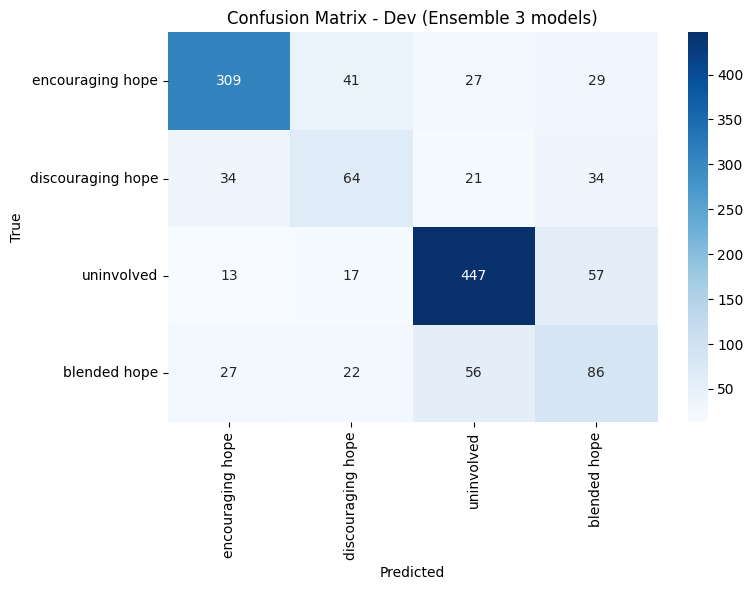

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# load DEV logits (upload or load from drive first)
xlmr_dev  = np.load("xlmr_dev_logits.npy")
muril_dev = np.load("muril_dev_logits.npy")
mbert_dev = np.load("mbert_dev_logits.npy")

# 3-model average ensemble on DEV
ens_dev = (xlmr_dev + muril_dev + mbert_dev) / 3.0
dev_preds_ens = ens_dev.argmax(axis=1)

y_true = dev_df["label_id"].values  # gold labels for dev

cm = confusion_matrix(y_true, dev_preds_ens,
                      labels=list(range(len(id2label))))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=[id2label[i] for i in range(len(id2label))],
    yticklabels=[id2label[i] for i in range(len(id2label))],
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Dev (Ensemble 3 models)")
plt.tight_layout()
plt.show()


In [25]:
def plot_ens3_confusion_matrix(path="confmat_ens3_dev.png"):
    cm = confusion_matrix(y_true, dev_preds_ens,
                          labels=list(range(len(id2label))))

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=[id2label[i] for i in range(len(id2label))],
        yticklabels=[id2label[i] for i in range(len(id2label))],
        cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Dev (Ensemble 3 models)")
    plt.tight_layout()
    plt.savefig(path, dpi=300)
    plt.close()
    print(f"Confusion matrix saved to: {path}")

plot_ens3_confusion_matrix()


Confusion matrix saved to: confmat_ens3_dev.png
